### Showcase of Jack's rough draft of the laz -> DSM pipeline

Based on the lidar_tools workflow at https://github.com/uw-cryo/lidar_tools/blob/main/notebooks/DSM_processing_reproj.ipynb

* only works for a singular, local input laz
* relevant files include:
    * jack_laz_dsm_pipe_v1.py
    * filter_percentile.py

In [1]:
import json
import pdal
from jack_laz_dsm_pipe_v1 import (
    detect_input_crs_wkt,
    detect_output_utm_crs_g2139_wkt,
    create_pdal_pipeline,
    create_dsm_stage,
)
import sys, os

from pyproj import CRS, Transformer # jack_laz_dsm_pipe_v1.py
import sys # jack_laz_dsm_pipe_v1.py

import numpy as np # filter_percentile.py
import scipy #filter_percentile.py

%load_ext autoreload
%autoreload 2

In [2]:
print(f"Python: {sys.version.split()[0]}")
print(f"JSON: {json.__version__ if hasattr(json, '__version__') else 'Built-in'}")
print(f"PDAL Python: {pdal.__version__ if hasattr(pdal, '__version__') else 'Unknown'}")
!pdal --version
print(f"PyProj: {CRS.__module__.split('.')[0]}=={__import__('pyproj').__version__}")

print(f"NumPy: {np.__version__}")
print(f"scipy: {scipy.__version__}")

Python: 3.11.12
JSON: 2.0.9
PDAL Python: 3.4.5
--------------------------------------------------------------------------------
pdal 2.8.4 (git-version: 41abc8)
--------------------------------------------------------------------------------

PyProj: pyproj==3.7.1
NumPy: 2.2.5
scipy: 1.15.2


Here, we'll focus on a singular laz tile over the Mt St Helens Caldera from the USGS 3DEP flight WA_FEMAHQ_B2A_2018

Downloaded from:

https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/WA_FEMAHQ_2018_D18/WA_FEMAHQ_B2A_2018/LAZ/USGS_LPC_WA_FEMAHQ_2018_D18_10TES6216.laz

In [3]:
# local LAZ file and base-template WKT
laz_file = "/home/jehayes/helens/test_laz_process/data/USGS_LPC_WA_FEMAHQ_2018_D18_10TES6216.laz"

# need this because our v1 output proj was WGS84 ensemble which is his tricky, 
# as then the proj pipelines do not apply the Helmert transform
# We can only ensure that if we specify a particular version of the WGS84 ensemble
base_utm_wkt = "/home/jehayes/Stereotypical_Helens/UTM_10N_WGS84_G2139_3D.wkt"

# Build a small AOI box in lon/lat
# just for testing the clipping/masking functionality
import geopandas as gpd
from shapely.geometry import box
smaller_box = box(-122.1950359, 46.19565097, -122.1848239, 46.20276185)
aoi = gpd.GeoDataFrame({'id': [1]}, geometry=[smaller_box], crs="EPSG:4326")

In [4]:
%%time
# CRS detection using new G2139‐aware function
input_wkt = detect_input_crs_wkt(laz_file)
# This writes + returns a new WKT in /tmp based on zone detected
output_wkt_path = detect_output_utm_crs_g2139_wkt(laz_file, base_utm_wkt)
# Read it in to pass to PDAL
with open(output_wkt_path, 'r') as f:
    output_wkt_text = f.read()

print("Input CRS snippet:", input_wkt[:200], "…")
print("Output CRS file:", output_wkt_path)
print("Output CRS snippet:", output_wkt_text[:200], "…")

Input CRS snippet: COMPD_CS["NAD83(2011) / UTM zone 10N + NAVD88 height - Geoid12B (meters)",PROJCS["NAD83(2011) / UTM zone 10N",GEOGCS["NAD83(2011)",DATUM["NAD83 (National Spatial Reference System 2011)",SPHEROID["GRS  …
Output CRS file: /tmp/UTM_10N_WGS84_G2139_3D.wkt
Output CRS snippet: PROJCRS["WGS 84 (G2139) / UTM 10N",
    BASEGEOGCRS["WGS 84 (G2139)",
    DYNAMIC[
        FRAMEEPOCH[2016]],
    DATUM["World Geodetic System 1984 (G2139)",
        ELLIPSOID["WGS 84",6378137,298.257 …
CPU times: user 17.3 s, sys: 2.08 s, total: 19.4 s
Wall time: 7.6 s


In [5]:
# Cell 4: Build PDAL pipeline with both outlier + RH98 filters baked in
pipeline_stages = create_pdal_pipeline(
    laz_file,
    aoi,
    filter_low_noise=True,      # strip class-7
    filter_high_noise=True,     # strip class-18
    #filter_road=True,           # strip class-11
    reset_classes=False,        # keep original classes
    reclassify_ground=False,    # no SMRF
    #return_only_ground=False,   # keep all returns
    group_filter=None,          # no return-group filter
    reproject=True,             # apply G2139 reprojection
    save_pointcloud=False,      # skip saving intermediate cloud
    pointcloud_file="ptcloud",
    input_crs=input_wkt,
    output_crs=output_wkt_path,
    output_type="laz",
    dsm_percentile=0.98, # DSM percentile RH98
    percentile_filter=True,
    percentile_threshold=0.95 # z-score noise trimming
)

In [6]:
pipeline_stages

[{'type': 'readers.las',
  'filename': '/home/jehayes/helens/test_laz_process/data/USGS_LPC_WA_FEMAHQ_2018_D18_10TES6216.laz'},
 {'type': 'filters.crop',
  'polygon': 'POLYGON ((562898.038690034 5116108.962674485, 562889.9249129579 5116899.054641361, 562102.082639925 5116891.014173023, 562110.0947601309 5116100.922125702, 562898.038690034 5116108.962674485))'},
 {'type': 'filters.range', 'limits': 'Classification![7:7]'},
 {'type': 'filters.outlier',
  'method': 'statistical',
  'multiplier': 3.0,
  'mean_k': 8},
 {'type': 'filters.range', 'limits': 'Classification![18:18]'},
 {'type': 'filters.reprojection',
  'in_srs': 'COMPD_CS["NAD83(2011) / UTM zone 10N + NAVD88 height - Geoid12B (meters)",PROJCS["NAD83(2011) / UTM zone 10N",GEOGCS["NAD83(2011)",DATUM["NAD83 (National Spatial Reference System 2011)",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY[

In [7]:
# Create DSM stage
# remember, we use 'max' because dsm_percentile=0.98 before gridding 
# causes RH98 returns to pass into the DSM stage
dem_stage = create_dsm_stage(
    dsm_filename="/tmp/helens_output_rh98_dsm.tif",
    pointcloud_resolution=1.0,
    gridmethod="max",
    dimension="Z"
)
# gap-fill window size
dem_stage[0]["window_size"] = 4
# Append to pipeline
pipeline_stages += dem_stage

In [8]:
dem_stage

[{'type': 'writers.gdal',
  'filename': '/tmp/helens_output_rh98_dsm.tif',
  'gdaldriver': 'GTiff',
  'nodata': -9999,
  'output_type': 'max',
  'resolution': 1.0,
  'gdalopts': 'COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES',
  'dimension': 'Z',
  'where': 'Z>0',
  'window_size': 4}]

In [9]:
pipeline_stages

[{'type': 'readers.las',
  'filename': '/home/jehayes/helens/test_laz_process/data/USGS_LPC_WA_FEMAHQ_2018_D18_10TES6216.laz'},
 {'type': 'filters.crop',
  'polygon': 'POLYGON ((562898.038690034 5116108.962674485, 562889.9249129579 5116899.054641361, 562102.082639925 5116891.014173023, 562110.0947601309 5116100.922125702, 562898.038690034 5116108.962674485))'},
 {'type': 'filters.range', 'limits': 'Classification![7:7]'},
 {'type': 'filters.outlier',
  'method': 'statistical',
  'multiplier': 3.0,
  'mean_k': 8},
 {'type': 'filters.range', 'limits': 'Classification![18:18]'},
 {'type': 'filters.reprojection',
  'in_srs': 'COMPD_CS["NAD83(2011) / UTM zone 10N + NAVD88 height - Geoid12B (meters)",PROJCS["NAD83(2011) / UTM zone 10N",GEOGCS["NAD83(2011)",DATUM["NAD83 (National Spatial Reference System 2011)",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY[

In [10]:
%%time
# Execute everything
pipeline_json = {"pipeline": pipeline_stages}
p = pdal.Pipeline(json.dumps(pipeline_json))
p.logoutput = "STDERR"
try:
    count = p.execute()
    print("Points processed:", count)
except Exception as e:
    print("Pipeline failed:", e)
    if hasattr(p, 'log'):
        print(p.log)

[filter_percentile] thr=0.95, z_val=1.64, orig=6813484, kept=6560652
[filter_local_pct] thr=0.98, cutoff=2255.10, orig=6813484, kept=136209


Points processed: 6813484
CPU times: user 1min 7s, sys: 978 ms, total: 1min 8s
Wall time: 1min 4s



---
#### Hooray, now let's look at our results

In [11]:
import xarray as xr
import rioxarray as rxr
import coincident
import matplotlib.pyplot as plt

/home/jehayes/mambaforge/envs/helens/lib/python3.11/site-packages/coincident/io/download.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/home/jehayes/mambaforge/envs/helens/lib/python3.11/site-packages/coincident/search/main.py:14: UserWarning: Unable to authenticate with Maxar API. Please set MAXAR_API_KEY environment variable.
  from coincident.search import neon_api, opentopo_api, stac, wesm


In [15]:
ds_custom_dsm = xr.open_dataset("/tmp/helens_output_rh98_dsm.tif").squeeze()

In [16]:
ds_custom_dsm

<xarray.Dataset> Size: 5MB
Dimensions:      (x: 796, y: 799)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 6kB 5.621e+05 5.621e+05 ... 5.629e+05 5.629e+05
  * y            (y) float64 6kB 5.117e+06 5.117e+06 ... 5.116e+06 5.116e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float64 5MB ...

In [17]:
ds_custom_dsm["hillshade"] = coincident.plot.gdaldem(
    ds_custom_dsm.band_data, "hillshade"
)

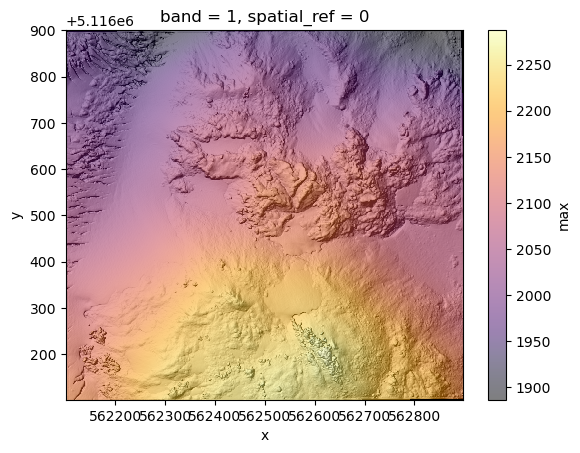

In [18]:
f, ax = plt.subplots()
ds_custom_dsm["hillshade"].squeeze().plot.imshow(cmap='gray', alpha=1, add_colorbar=False)
ds_custom_dsm.band_data.squeeze().plot.imshow(cmap='inferno', alpha=0.5);

Now, let's compare with the provider DEM

In [19]:
da_usgs_dem = coincident.io.xarray.load_usgs_dem(aoi, "WA_FEMAHQ_2018_D18",
                                                 clip=True)

In [20]:
da_usgs_dem

<xarray.DataArray 'elevation' (y: 799, x: 796)> Size: 3MB
dask.array<getitem, shape=(799, 796), dtype=float32, chunksize=(799, 796), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 6kB 5.621e+05 5.621e+05 ... 5.629e+05 5.629e+05
  * y            (y) float64 6kB 5.117e+06 5.117e+06 ... 5.116e+06 5.116e+06
    spatial_ref  int64 8B 0

In [21]:
from osgeo import gdal
# probably a better way to do this but this works for deomstrative purposes
temp_path = "/tmp/temp_dem.tif"
da_usgs_dem.rio.to_raster(temp_path)
gdal.Warp("/tmp/usgs_dem.tif", temp_path, srcSRS=input_wkt, dstSRS=output_wkt_text, format="GTiff")
da_usgs_dem = rxr.open_rasterio("/tmp/usgs_dem.tif").squeeze()

In [22]:
ds_custom_dsm.rio.crs

In [23]:
if da_usgs_dem.rio.crs is None:
    da_usgs_dem.rio.write_crs(output_wkt_text, inplace=True)
if ds_custom_dsm.rio.crs is None:
    ds_custom_dsm.rio.write_crs(output_wkt_text, inplace=True)
da_usgs_dem = da_usgs_dem.rio.reproject_match(ds_custom_dsm)

In [24]:
da_usgs_hillshade = coincident.plot.gdaldem(
    da_usgs_dem, "hillshade"
)

In [25]:
ds_custom_dsm.rio.resolution(), da_usgs_dem.rio.resolution()

((1.0, -1.0), (1.0, -1.0))

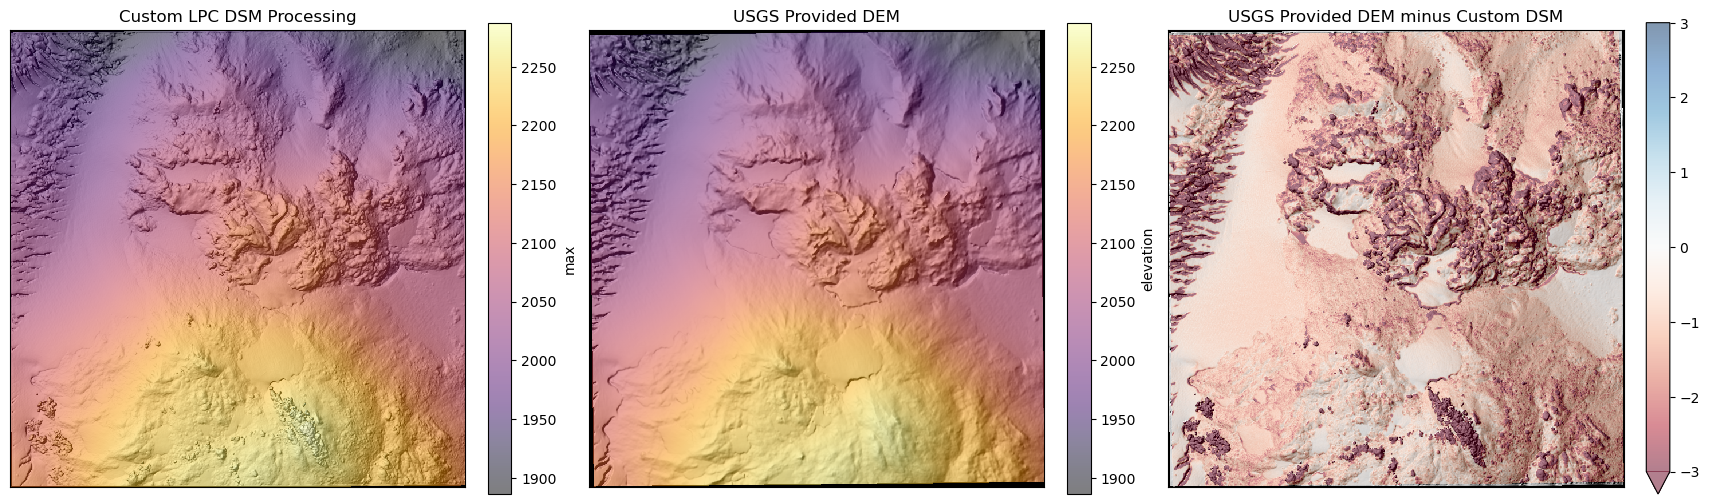

In [26]:
# Get combined min/max for elevation data
vmin_elev = min(ds_custom_dsm.band_data.min().item(), da_usgs_dem.min().item())
vmax_elev = max(ds_custom_dsm.band_data.max().item(), da_usgs_dem.max().item())

f, axs = plt.subplots(1,3,figsize=(17,5), layout='constrained')

ax=axs[0]
ds_custom_dsm["hillshade"].squeeze().plot.imshow(ax=ax, cmap='gray', alpha=1, add_colorbar=False)
ds_custom_dsm.band_data.squeeze().plot.imshow(ax=ax, cmap='inferno', alpha=0.5, vmin=vmin_elev, vmax=vmax_elev)
ax.set_title("Custom LPC DSM Processing")
ax.set_aspect('equal')

ax=axs[1]
da_usgs_hillshade.plot.imshow(ax=ax, cmap='gray', alpha=1, add_colorbar=False)
da_usgs_dem.plot.imshow(ax=ax, cmap='inferno', alpha=0.5, vmin=vmin_elev, vmax=vmax_elev)
ax.set_title("USGS Provided DEM")
ax.set_aspect('equal')

ax=axs[2]
da_diff = da_usgs_dem - ds_custom_dsm.band_data.squeeze()
ds_custom_dsm["hillshade"].squeeze().plot.imshow(ax=ax, cmap='gray', alpha=1, add_colorbar=False)
da_diff.plot.imshow(ax=ax, cmap='RdBu', alpha=0.5, vmin=-3, vmax=3)
ax.set_title("USGS Provided DEM minus Custom DSM")
ax.set_aspect('equal')

for ax in axs:
    ax.set(xticks=[],yticks=[],
           ylabel="",xlabel="");